In [1]:
from stacked_mnist import *
from verification_net import VerificationNet
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from autoencoder import Autoencoder
from util import *
from vae_model import VAE
from engine import *
from torchvision.utils import make_grid
from tqdm import tqdm
import seaborn as sns

In [2]:
BATCH_SIZE = 256

data = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE)

train_dataset = data.get_full_data_set(training=True)
test_dataset = data.get_full_data_set(training=False)



class StackedMnistDataset(Dataset):
    def __init__(self, data):
        self.X = torch.from_numpy(data[0]).float()
        self.y = torch.from_numpy(data[1]).float()
        # turn them into long tensors
        self.y = self.y.long()
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

mono_mnist_train = StackedMnistDataset(train_dataset)
mono_mnist_test = StackedMnistDataset(test_dataset)

train_loader = DataLoader(mono_mnist_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(mono_mnist_test, batch_size=BATCH_SIZE, shuffle=False)

In [3]:
for x, y in train_loader:
    # reshape to (batch_size, num_channels, height, width)
    #x = x.reshape(-1, 3, 28, 28)
    print(x.shape)
    print(y.shape)
    break

torch.Size([256, 28, 28, 1])
torch.Size([256])


In [4]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

try:
    model = torch.load("./models/vae_gen", map_location=device)
    model.to(device)
    print("Loaded model from file")

except:
    print("couldnt load")

device: cuda
Loaded model from file


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initialize the model
model = VAE().to(device)
# set the learning parameters
lr = 0.001
epochs = 100
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

Epoch 1 of 100 | train loss: 67395.99 | val loss:67395.99
Epoch 2 of 100 | train loss: 47612.04 | val loss:47612.04
Epoch 3 of 100 | train loss: 40356.5 | val loss:40356.5
Epoch 4 of 100 | train loss: 35129.2 | val loss:35129.2
Epoch 5 of 100 | train loss: 32760.99 | val loss:32760.99
Epoch 6 of 100 | train loss: 30742.86 | val loss:30742.86
Epoch 7 of 100 | train loss: 29131.52 | val loss:29131.52
Epoch 8 of 100 | train loss: 28206.15 | val loss:28206.15
Epoch 9 of 100 | train loss: 27363.75 | val loss:27363.75
Epoch 10 of 100 | train loss: 26599.33 | val loss:26599.33
Epoch 11 of 100 | train loss: 25993.28 | val loss:25993.28
Epoch 12 of 100 | train loss: 25489.58 | val loss:25489.58
Epoch 13 of 100 | train loss: 25147.5 | val loss:25147.5
Epoch 14 of 100 | train loss: 24900.22 | val loss:24900.22
Epoch 15 of 100 | train loss: 24638.93 | val loss:24638.93
Epoch 16 of 100 | train loss: 24449.17 | val loss:24449.17
Epoch 17 of 100 | train loss: 24264.92 | val loss:24264.92
Epoch 18 of 

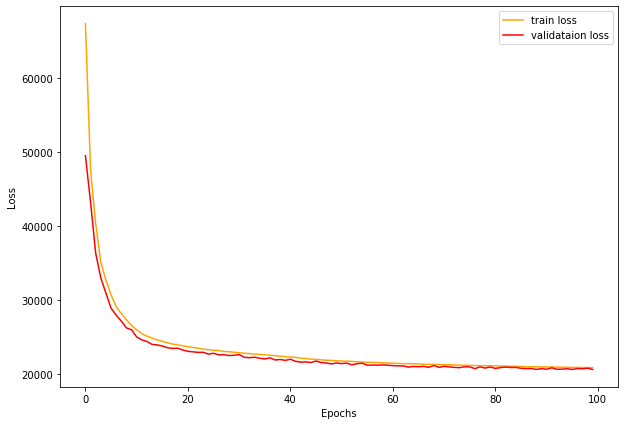

In [6]:
train_loss = []
valid_loss = []
outputs = []
grid_images = []
for epoch in range(epochs):
    train_epoch_loss = train(model, train_loader, mono_mnist_train, device, optimizer, criterion)
    valid_epoch_loss, recon_images = validate(
        model, test_loader, mono_mnist_test, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)

    print(f"Epoch {epoch+1} of {epochs} | train loss: {round(train_epoch_loss, 2)} | val loss:{round(train_epoch_loss, 2)}")

image_to_vid(grid_images)
save_loss_plot(train_loss, valid_loss)

In [7]:
torch.save(model, "./models/vae_gen")

In [8]:
def generate_test_images(model, dataloader, device):
    outputs = []
    labels = []
    model.eval()
    with torch.no_grad():
        for image, label in dataloader:
            # pytorch
            num_channels = image.shape[-1]
            image = image.reshape(-1, num_channels, 28, 28)

            image = image.to(device)
            output, _, _ = model(image)
            # keras
            output = output.reshape(-1, 28, 28, num_channels)

            outputs.append(output)
            labels.append(label)
    return torch.concatenate(outputs), torch.concatenate(labels)

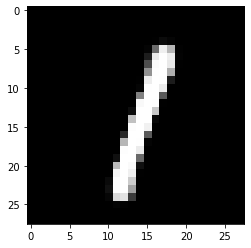

In [9]:
im, label = next(iter(test_loader))
im = im.reshape(-1, 1, 28, 28)
im = im.to(device)
out, mu, logvar = model(im)
out = out.cpu().detach().numpy().reshape(-1, 28, 28)
plt.imshow(out[5], cmap="gray")

In [10]:
test_outputs, test_labels = generate_test_images(model, test_loader, device)
test_outputs = test_outputs.cpu().numpy()
test_labels = test_labels.cpu().numpy()

In [11]:
verification_net = VerificationNet()
predictability, accuracy = verification_net.check_predictability(test_outputs, test_labels, tolerance=0.8)
coverage = verification_net.check_class_coverage(test_outputs, tolerance=0.8)
print(f"Predictability: {predictability} \nAccuracy: {accuracy} \nCoverage: {coverage}")

Predictability: 0.803 
Accuracy: 0.7563 
Coverage: 1.0


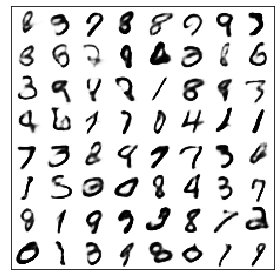

Predictability: 0.578125 
Accuracy: None 
Coverage: 0.9


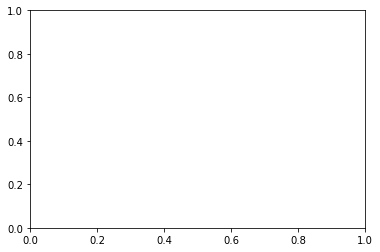

In [42]:
z = torch.normal(0,1, size=(64,16)).to(device)
generative_out = model.decoder(z).cpu().detach().numpy().reshape(-1, 28, 28, 1)
generative_out_tile = generative_out.squeeze()
tiled_image = tile_images(generative_out_tile, show=True)

generative_predictability, generative_accuracy = verification_net.check_predictability(generative_out, tolerance=0.8)
generative_coverage = verification_net.check_class_coverage(generative_out, tolerance=0.8)
print(f"Predictability: {generative_predictability} \nAccuracy: {generative_accuracy} \nCoverage: {generative_coverage}")